In [3]:
import numpy as np
import matplotlib as plt
import pandas as pd
from alpha_vantage.timeseries import TimeSeries # This is used for generating the real time data
import time
from sklearn.ensemble import RandomForestClassifier

In [4]:
api_key = "MNNSPRF08WG4DTL3"
time_series = TimeSeries(key = api_key, output_format = "pandas")
data,meta_data = time_series.get_daily(symbol = "MSFT",outputsize = "full") # change to full later on

data = data.rename(columns = {
    '1. open' : 'Open',
    '2. high' : 'High',
    '3. low' : 'Low',
    '4. close' : 'Close',
    '5. volume' : 'Volume',
    
})


data['Open-Close'] = (data.Open - data.Close)/data.Open
data['High-Low'] = (data.High - data.Low)/data.Low
data['percent_change'] = data['Close'].pct_change()
data['std_5'] = data['percent_change'].rolling(5).std()
data['ret_5'] = data['percent_change'].rolling(5).mean()
data.dropna(inplace=True)

# X is the input variable
X = data[['Open-Close', 'High-Low', 'std_5', 'ret_5']]

# Y is the target or output variable
y = np.where(data['Close'].shift(-1) > data['Close'], 1, -1)


In [5]:
# Total dataset length
dataset_length = data.shape[0]

# Training dataset length
split = int(dataset_length * 0.80)
split

4021

In [6]:
# Splitiing the X and y into train and test datasets
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Print the size of the train and test dataset
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(4021, 4) (1006, 4)
(4021,) (1006,)


In [7]:
clf = RandomForestClassifier(random_state=5)

In [8]:
# Create the model on train dataset
model = clf.fit(X_train, y_train)

In [9]:
from sklearn.metrics import accuracy_score
print('Correct Prediction (%): ', accuracy_score(y_test, model.predict(X_test), normalize=True)*100.0)

Correct Prediction (%):  49.70178926441352


In [10]:
# Run the code to view the classification report metrics
from sklearn.metrics import classification_report
report = classification_report(y_test, model.predict(X_test))
print(report)

             precision    recall  f1-score   support

         -1       0.46      0.63      0.53       458
          1       0.55      0.39      0.46       548

avg / total       0.51      0.50      0.49      1006



In [11]:
data['strategy_returns'] = data.percent_change.shift(-1) * model.predict(X)

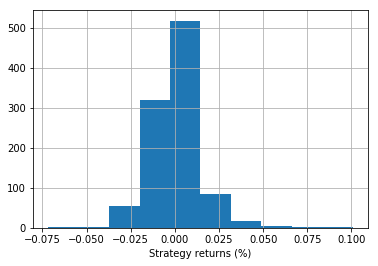

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
data.strategy_returns[split:].hist()
plt.xlabel('Strategy returns (%)')
plt.show()

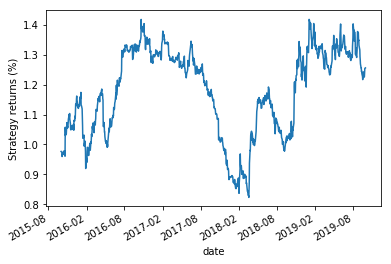

In [13]:
(data.strategy_returns[split:]+1).cumprod().plot()
plt.ylabel('Strategy returns (%)')
plt.show()